<a href="https://colab.research.google.com/github/itz-rakshitha5/Generative-AI/blob/main/Generative_Adversial_Network%5BGAI%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GAN(Generative Adversial Network)**

# 1. Import Necessasary Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# 2. Define a Transform
uses pytorch's transform to define a simple picture transforms.Compose and normalizes photos into tensors

In [ ]:
# Define a basic transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 3. Load the Dataset

In [ ]:
train_dataset = datasets.CIFAR10(root='./data',\
              train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(train_dataset, \
                                batch_size=32, shuffle=True)


100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


# 4. Set The Hyperparameters

In [ ]:
# Hyperparameters
latent_dim = 100
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
num_epochs = 10


# 5. Define the Generator

In [ ]:
# Define the generator
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

# 6. Define the Discriminator


In [ ]:
# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25),
        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        nn.ZeroPad2d((0, 1, 0, 1)),
        nn.BatchNorm2d(64, momentum=0.82),
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(128, momentum=0.82),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25),
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256, momentum=0.8),
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(256 * 5 * 5, 1),
        nn.Sigmoid()
    )

    def forward(self, img):
        validity = self.model(img)
        return validity


# 7. Building The GAN

In [ ]:
# Define the generator and discriminator
# Initialize generator and discriminator
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
# Loss function
adversarial_loss = nn.BCELoss()
# Optimizers
optimizer_G = optim.Adam(generator.parameters()\
                         , lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters()\
                         , lr=lr, betas=(beta1, beta2))


# 8. Train the Model

Epoch [1/10]                        Batch 100/1563 Discriminator Loss: 0.7581 Generator Loss: 1.1394
Epoch [1/10]                        Batch 200/1563 Discriminator Loss: 0.6738 Generator Loss: 0.7794
Epoch [1/10]                        Batch 300/1563 Discriminator Loss: 0.4469 Generator Loss: 1.6569
Epoch [1/10]                        Batch 400/1563 Discriminator Loss: 0.4990 Generator Loss: 1.3185
Epoch [1/10]                        Batch 500/1563 Discriminator Loss: 0.4311 Generator Loss: 1.3515
Epoch [1/10]                        Batch 600/1563 Discriminator Loss: 0.5511 Generator Loss: 1.1063
Epoch [1/10]                        Batch 700/1563 Discriminator Loss: 0.8043 Generator Loss: 0.8329
Epoch [1/10]                        Batch 800/1563 Discriminator Loss: 0.6521 Generator Loss: 1.0660
Epoch [1/10]                        Batch 900/1563 Discriminator Loss: 0.6121 Generator Loss: 1.2304
Epoch [1/10]                        Batch 1000/1563 Discriminator Loss: 0.6593 Generator Lo

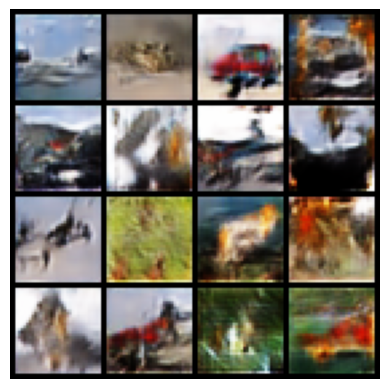

In [ ]:
# Training loop
for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):
       # Convert list to tensor
        real_images = batch[0].to(device)
        # Adversarial ground truths
        valid = torch.ones(real_images.size(0), 1, device=device)
        fake = torch.zeros(real_images.size(0), 1, device=device)
        # Configure input
        real_images = real_images.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        # Sample noise as generator input
        z = torch.randn(real_images.size(0), latent_dim, device=device)
        # Generate a batch of images
        fake_images = generator(z)

        # Measure discriminator's ability
        # to classify real and fake images
        real_loss = adversarial_loss(discriminator\
                                     (real_images), valid)
        fake_loss = adversarial_loss(discriminator\
                                     (fake_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        # Backward pass and optimize
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()
        # Generate a batch of images
        gen_images = generator(z)
        # Adversarial loss
        g_loss = adversarial_loss(discriminator(gen_images), valid)
        # Backward pass and optimize
        g_loss.backward()
        optimizer_G.step()
        # ---------------------
        #  Progress Monitoring
        # ---------------------
        if (i + 1) % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}]\
                        Batch {i+1}/{len(dataloader)} "
                f"Discriminator Loss: {d_loss.item():.4f} "
                f"Generator Loss: {g_loss.item():.4f}"
            )
    # Save generated images for every epoch
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_dim, device=device)
            generated = generator(z).detach().cpu()
            grid = torchvision.utils.make_grid(generated,\
                                        nrow=4, normalize=True)
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            plt.axis("off")
            plt.show()
